# QCut Basic Usage

In [1]:
import QCut as ck
from QCut import cut, cutGate
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import CXGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import CXGate
from qiskit_aer import AerSimulator
from qiskit.primitives import Estimator, BackendEstimator
from iqm.qiskit_iqm import IQMFakeAdonis

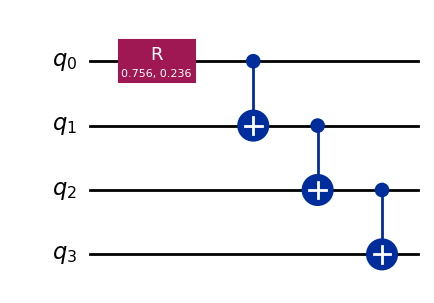

In [2]:
#define initial circuit

circuit  =  QuantumCircuit(4)

mult = 1.635
circuit.r(mult*0.46262, mult*0.1446, 0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.cx(2,3)
   
circuit.draw("mpl")

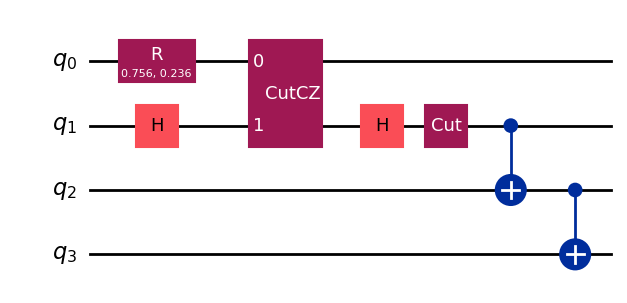

In [22]:
#insert cuts

from qiskit.circuit.library import CXGate

cut_circuit = QuantumCircuit(4)

mult = 1.635
cut_circuit.r(mult*0.46262, mult*0.1446, 0)
cut_circuit.append(**cutGate(CXGate(), 0, 1)) 
cut_circuit.append(cut, [1])
cut_circuit.cx(1,2)
cut_circuit.cx(2,3)

cut_circuit.decompose(["CutGate"]).draw("mpl")


In [ ]:
#extract cut locations and separate into subcircuits

cut_circuit = ck.get_locations_and_subcircuits(cut_circuit)

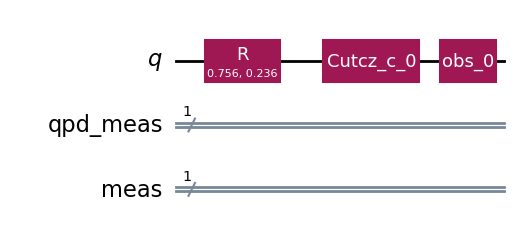

In [ ]:
cut_circuit.subcircuits[0].draw("mpl")

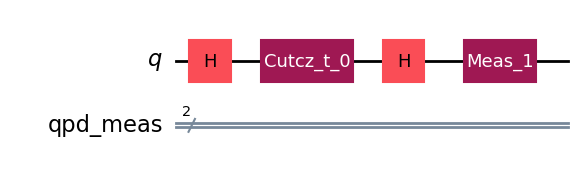

In [ ]:
cut_circuit.subcircuits[1].draw("mpl")

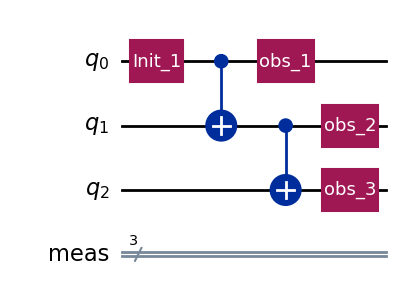

In [ ]:
cut_circuit.subcircuits[2].draw("mpl")

In [27]:
#define backends
fake = IQMFakeAdonis()
sim = AerSimulator()

In [ ]:
#transpile subcircuits for backend

transpiled = ck.transpile_subcircuits(cut_circuit, fake, optimization_level=3)

In [ ]:
#generate experiment circuits
observables = SparsePauliOp(["IIIZ", "IIZI", "IZII", "IIZZ"])

cut_experiment = ck.get_experiment_circuits(transpiled, observables)

In [ ]:
#run experiment circuits
#run_experiments() also post processes the results

results = ck.run_experiments(cut_experiment, backend=fake)

In [ ]:

#get the approximated expectation values
expectation_values = ck.estimate_expectation_values(results, cut_experiment.expv_data())

In [ ]:
obs = [ob.to_label() for ob in observables.paulis]

estimator = Estimator()
exact_expvals = (
    estimator.run([circuit] * len(obs), obs).result().values
)


tr = transpile(circuit, backend=fake)

tr_obs = observables.apply_layout(tr.layout)

tr_obs_separate = [
    SparsePauliOp(pauli.to_label()) for pauli in tr_obs.paulis
]

fake_estimator = BackendEstimator(fake)
exps = (
    fake_estimator.run([tr] * len(tr_obs_separate), tr_obs_separate).result().values
)

In [ ]:
import numpy as np

np.set_printoptions(formatter={"float": lambda x: f"{x:0.6f}"})

print(f"QCut expectation values:{np.array(expectation_values)}")
print(f"Noisy expectation values with fake backend:{np.array(exps)}")
print(f"Exact expectation values with ideal simulator :{np.array(exact_expvals)}")

QCut expectation values:[0.618428 0.537705 0.567099 0.798735]
Noisy expectation values with fake backend:[0.516602 0.611328 0.559570 0.687500]
Exact expectation values with ideal simulator :[0.727323 0.727323 0.727323 1.000000]
